In [81]:
model = load_model("ml_models/cnn_2022_7_20_fpe.h5")
fbins = np.array([4000*1.0445**i for i in range(96)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 8)             40        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 16)            528       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 8)                 1

In [72]:
layer = model.get_layer(name="dense_3")
#feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)
weights = np.array(layer.get_weights())[0]
print((weights))

[[0.06760126]
 [0.05066645]
 [0.04403219]
 [0.3311286 ]]


/tmp/ipykernel_1707/893141273.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weights = np.array(layer.get_weights())[0]


In [30]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


In [31]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [32]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform(shape=(1,96))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 5000
    learning_rate = .1
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    #img = deprocess_image(img[0].numpy())
    return loss, img


In [33]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    #img = img[25:-25]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

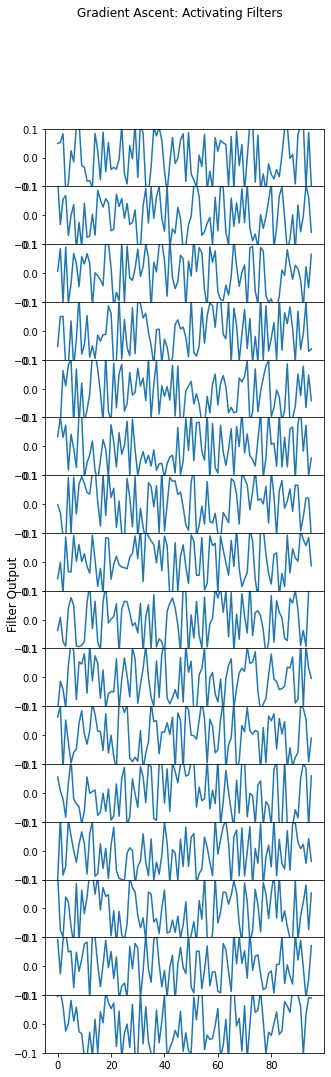

In [52]:
plots = 16
fig, ax = plt.subplots(plots, figsize=(5, plots+1))
plt.subplots_adjust(hspace=0)
fig.suptitle("Gradient Ascent: Activating Filters")
fig.supxlabel("")
fig.supylabel("Filter Output")
for i in range(plots):
    loss, img = visualize_filter(i)
    ax[i].plot(img[0])
    #ax[i].set_yscale('log')
    ax[i].set_ylim((-.1,.1))
    #ax[i].text(1,100,f"Filter: {i}")

In [25]:
for i in range(8):
    loss, img = visualize_filter(i)
    print(img)

KeyboardInterrupt: 